In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, classification_report
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_selection import mutual_info_classif
import warnings
warnings.filterwarnings('ignore')


df = pd.read_excel('xlsx_all_data.xlsx', index_col=0)

Xcombined = pd.concat([df.iloc[:, 3:19], df.iloc[:, 20:-1]], axis=1)
yhome_win = df.iloc[:, -1:]

In [2]:
Xcombined_train = Xcombined.iloc[:4000, :]
Xcombined_test = Xcombined.iloc[4000:, :]

yhome_win_train = yhome_win.iloc[:4000, :]
yhome_win_test = yhome_win.iloc[4000:, :]

<Axes: >

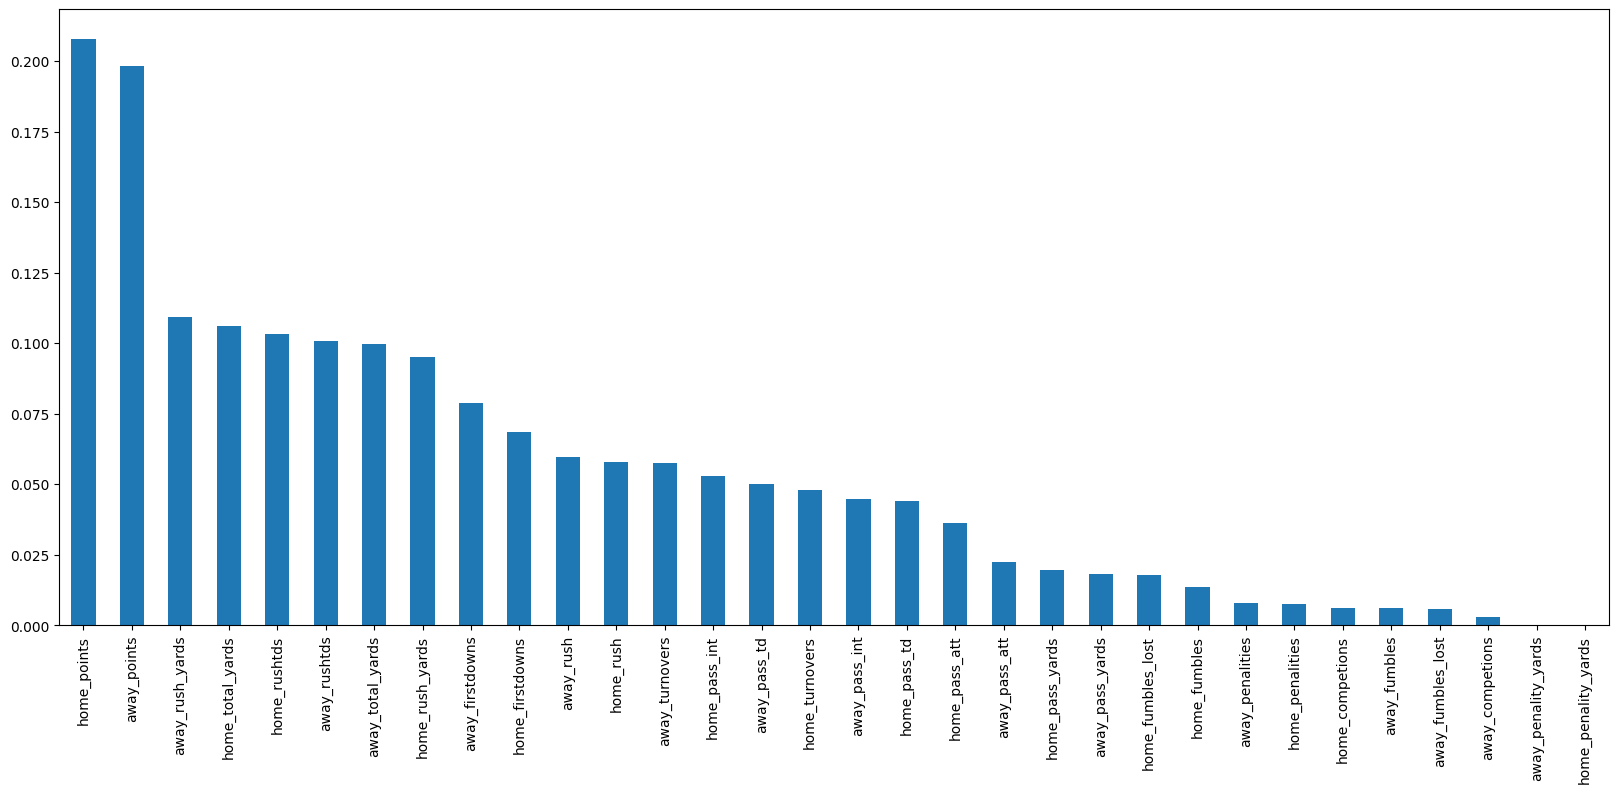

In [3]:
mutual_info = mutual_info_classif(Xcombined_train, yhome_win_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = Xcombined_train.columns
mutual_info.sort_values(ascending=False)
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))

<Axes: >

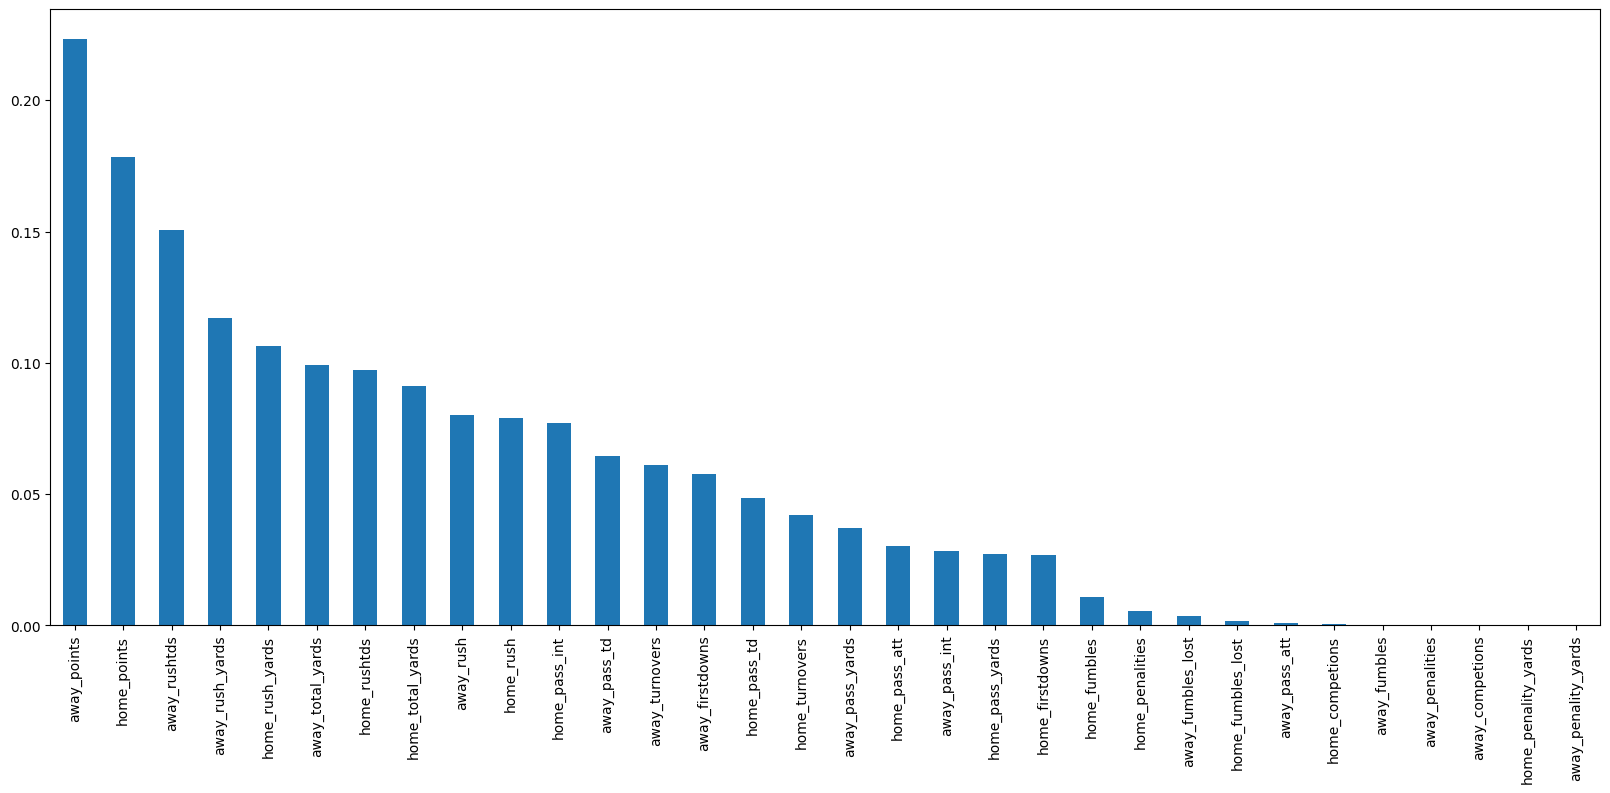

In [4]:
mutual_info = mutual_info_classif(Xcombined_test, yhome_win_test)
mutual_info = pd.Series(mutual_info)
mutual_info.index = Xcombined_test.columns
mutual_info.sort_values(ascending=False)
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [5]:
# Making sparse matrix (for easier/quicklier calculating) X_train_sparse 
Xcombined_sparse = csr_matrix((np.ones(Xcombined.values.size, dtype=int),
                               Xcombined.values.reshape(-1),
                               np.arange(Xcombined.values.shape[0] + 1) * Xcombined.values.shape[1]))[:, 1:]

X_train_sparse = Xcombined_sparse[:Xcombined_train.shape[0]]
X_test_sparse = Xcombined_sparse[Xcombined_train.shape[0]:]
y = yhome_win_train.values

print(X_train_sparse.shape[0], X_train_sparse.shape[1], X_test_sparse.shape[0], X_test_sparse.shape[1])

4000 826 950 826


In [6]:
train_share = int(.7 * X_train_sparse.shape[0])
X_train, y_train = X_train_sparse[:train_share, :], y[:train_share]
X_valid, y_valid  = X_train_sparse[train_share:, :], y[train_share:]

In [7]:
sgd_logit = SGDClassifier(loss='log_loss', random_state=17, n_jobs=-1)

# ALSO SHOULD BE TRIED AND MODELS COMPARED BETWEEN EACH OTHER 
# logreg = LogisticRegression(random_state=17, parameters(?))
# rf_clf = RandomForestClassifier(parameters(?))
# knn_clf = KNeighborsClassifier(parameters(?))
# svc_clf = SVC(parameters(?))
# gb_clf = GradientBoostingClassifier(random_state=SEED, parameters(?))

sgd_logit.fit(X_train, y_train)

SGDClassifier(loss='log_loss', n_jobs=-1, random_state=17)

Make a prediction in terms of the predicted probabilities that this is True (Home_Win) on a delayed sample (X_test, y_test).*

In [8]:
logit_valid_pred_proba = sgd_logit.predict_proba(X_valid)

ROC AUC describes the relationship between the sensitivity of the model (TPR, or true positives rate - the proportion of true positive examples) and its specificity (described in terms of the proportion of false positives: 1-FPR).

In [9]:
print(round(roc_auc_score(y_valid, logit_valid_pred_proba[:, 1]), 3))

0.512


Here is would be def feature_engineering():

several new columns should be added to already existed. But I can not imagine any new features, because I have problems with the game's rules

preprocessing import OneHotEncoder, StandardScaler. 
Yesteraday I used StandardScaler, but The Standard Scaler assumes that the data is normally distributed within each function. Distribution analysis is still needed (statistics).

In [19]:
params = {
    'loss': ['modified_huber'],
    'penalty': ['l1'],
    'alpha': [0.1],
    'max_iter': np.arange(100, 1000, 100)
}
sgd_logit = SGDClassifier(n_jobs=-1, random_state=17)
grid = GridSearchCV(sgd_logit, param_grid=params, cv=10)
grid.fit(X_train_sparse, y)
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)
grid.best_estimator_.fit(X_train_sparse, y)
best_logit_valid_pred_proba = grid.best_estimator_.predict_proba(X_test_sparse)

{'alpha': 0.1, 'loss': 'modified_huber', 'max_iter': 100, 'penalty': 'l1'}
0.6207500000000001
SGDClassifier(alpha=0.1, loss='modified_huber', max_iter=100, n_jobs=-1,
              penalty='l1', random_state=17)
